In [ ]:
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
np.exp(1)

2.718281828459045

In [3]:
e = np.exp(3)
data = (e - 1/e)/(e + 1/e)
data

0.9950547536867306

In [ ]:
class Node:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out_value = Node(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out_value.grad
            other.grad += 1.0 * out_value.grad
            
        out_value._backward = _backward
            
        return out_value
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out_value = Node(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out_value.grad
            other.grad += self.data * out_value.grad
        
        out_value._backward = _backward
            
        return out_value

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/ float can be used for pow"
        out_value = Node(self.data ** other, (self,))
        
        def _backward():
            self.grad += (other) * (self.data ** (other-1)) * out_value.grad
            
        out_value._backward = _backward
        return out_value
    
    def exp(self):
        out_value = Node(np.exp(self.data), (self,))
        
        def _backward():
            self.grad += out_value.data * out_value.grad
            
        out_value._backward = _backward
        return out_value
    
    def tanh(self):
        e = self.exp()
        data = (e - 1/e)/(e + 1/e)
        out_value = Node( data.data, (self,) )
        
        def _backward():
            self.grad += (1 - (out_value.data)**2) * out_value.grad
            
        out_value._backward = _backward
        return out_value
    
    def relu(self):
        out_value = Node( 0 if self.data < 0 else self.data, (self,))
        
        def _backward():
            self.grad += (out_value.data > 0) * out_value.grad
        out_value._backward = _backward
        return out_value
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return -1 * (self)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other ** -1) 
    def __rtruediv__(self, other):
        return other * (self ** -1) 
    
    def backward(self):
        topo, visited = [], set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                #print(v)
                topo.append(v)
        topological_sort(self)
        
        # set current self grad to 1
        self.grad = 1
        for v in reversed(topo):
            #print(v)
            v._backward()
 
    
    def __repr__(self):
        return (f"Node(data={self.data}, grad={self.grad})")

    def trace(root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build(child)
        build(root)
        return nodes, edges

    def draw_dot(self, format='svg', rankdir='LR'):
        """
        format: png | svg | ...
        rankdir: TB (top to bottom graph) | LR (left to right)
        """
        assert rankdir in ['LR', 'TB']
        nodes, edges = self.trace()
        dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

        for n in nodes:
            dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
            if n._op:
                dot.node(name=str(id(n)) + n._op, label=n._op) 
                dot.edge(str(id(n)) + n._op, str(id(n)))

        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

        return dot


In [8]:
2 + a

Node(data=5, grad=0)

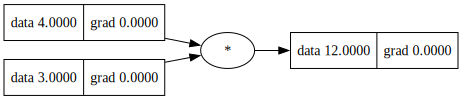

In [7]:
a = Node(3)
b = Node(4)

c = a*b
c.draw_dot()

In [12]:
c.backward()

Node(data=3, grad=0)
Node(data=4, grad=0)
Node(data=12, grad=0)
Node(data=12, grad=1)
Node(data=4, grad=3)
Node(data=3, grad=4)


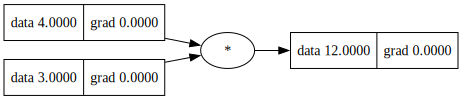

In [9]:
c.draw_dot()

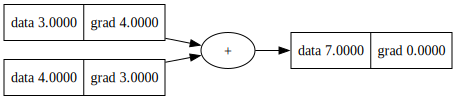

In [14]:
d = a+b
d.draw_dot()

In [15]:
d.backward()

Node(data=3, grad=4)
Node(data=4, grad=3)
Node(data=7, grad=0)
Node(data=7, grad=1)
Node(data=4, grad=4)
Node(data=3, grad=5)


In [16]:
def f(x):
    return 4*(x**2) - 2*x + 3

f(4)

59

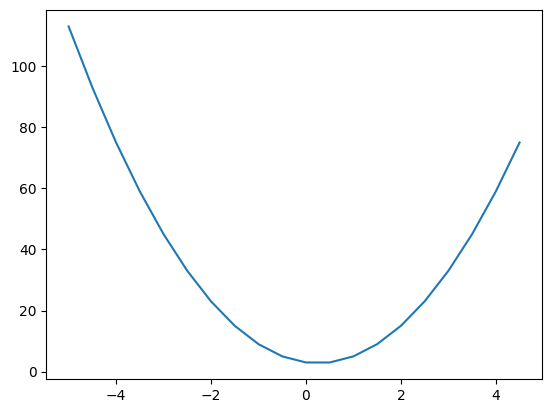

In [17]:
xs = np.arange(-5,5,0.5)

plt.plot(xs, f(xs))
plt.show()

In [18]:
# 8x -2

h=0.01
d1 = f(4)
d2 = f(4 +h)

print(d1, d2, (d2 -d1)/ h)

59 59.300399999999996 30.039999999999623


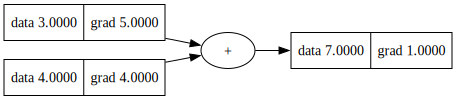

In [19]:
d.draw_dot()

In [10]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
            
        def parameters(self):
            return []

class Neuron(Module):
    def __init__(self, n):
        self.w = [Node(random.uniform(-1, 1)) for i in range(n)]
        self.b = Node(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum(([wi * xi for wi,xi in zip(self.w, x)]), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
class Layer(Module):
    def __init__(self,n_inputs, n_neurons):
        self.neurons = [Neuron(n_inputs) for i in range(n_neurons)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP(Module):
    def __init__(self, n_inputs, l_layers):
        size = [n_inputs] +l_layers
        self.layers = [Layer(size[i] , size[i+1]) for i in range(len(l_layers))]
        
    def __call__(self, x):
        outs = [l(x) for l in self.layers]
        return outs[-1]

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
    

In [11]:
n = Layer(2, 3)
m = MLP(2, [3,3,4])
m([2.0, 3])

[Node(data=0.9777247188303093, grad=0),
 Node(data=-0.6131590446897256, grad=0),
 Node(data=0.6455188423547855, grad=0),
 Node(data=0.9684794176937471, grad=0)]

## Testing

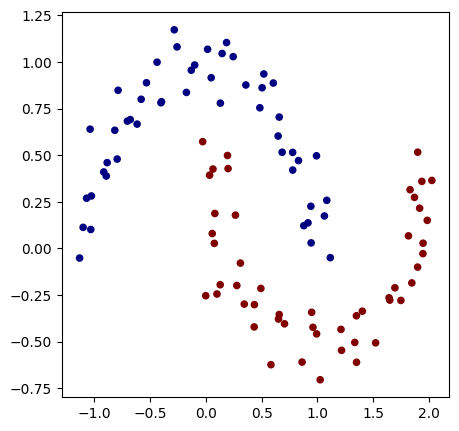

In [12]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [38]:
# initialize a model 
model = MLP(2, [32, 128, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 6401


In [18]:
# loss function
def calc_loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Node, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = calc_loss()
print(total_loss, acc)

Node(data=1.031746358700779, grad=0) 0.5


In [40]:
for i in range(20):
    # forwards pass
    outs = list(map(model, X))
    #outs = [model(i) for i in xs]
    loss = sum( (yi - yh)**2 for yi,yh in zip(outs, y) )
    #loss, _ = calc_loss()
    print(loss.data)
    
    model.zero_grad()
    # backward pass
    loss.backward()
    
    #udpate weights
    #lr = 1.0 - 0.9*i/100
    for n in model.parameters():
        n.data -= 0.01 * n.grad

38.21934379579122
38.17767738185983
38.14244103221125
38.112487582667576
38.086906246047015
38.0649670387881
38.046079871180034
38.029764027181045
38.01562511773286
38.00333748406624
37.992630625324296
37.983278632023094
37.97509188846495
37.96791050468368
37.96159907875096
37.95604249107259
37.951142505547864
37.94681500623693
37.94298773803605
37.93959844966529


In [24]:
model.parameters()

[Node(data=0.41300152038979876, grad=0.0),
 Node(data=0.7407384376941248, grad=0.0),
 Node(data=-0.8610651186882945, grad=0.0),
 Node(data=0.3522185896840426, grad=0.0),
 Node(data=-0.5050012448918071, grad=0.0),
 Node(data=-0.15237316042823723, grad=0.0),
 Node(data=-0.7037638996691695, grad=0.0),
 Node(data=0.6651804644732082, grad=0.0),
 Node(data=-0.11996397085779176, grad=0.0),
 Node(data=0.8299433781202121, grad=0.0),
 Node(data=-0.4880067333185212, grad=0.0),
 Node(data=-0.9940640968130581, grad=0.0),
 Node(data=0.8873719996258655, grad=0.0),
 Node(data=-0.9345164645950266, grad=0.0),
 Node(data=-0.9997108905607577, grad=0.0),
 Node(data=0.11100098907549416, grad=0.0),
 Node(data=0.5648982762318917, grad=0.0),
 Node(data=0.05957458226430856, grad=0.0),
 Node(data=-0.7659205352452185, grad=0.0),
 Node(data=0.5761957019295414, grad=0.0),
 Node(data=-0.3788403565911471, grad=0.0),
 Node(data=0.26997293218294716, grad=0.0),
 Node(data=-0.20043674609522255, grad=0.0),
 Node(data=-0.3

(-1.7041114267794097, 2.0458885732205903)

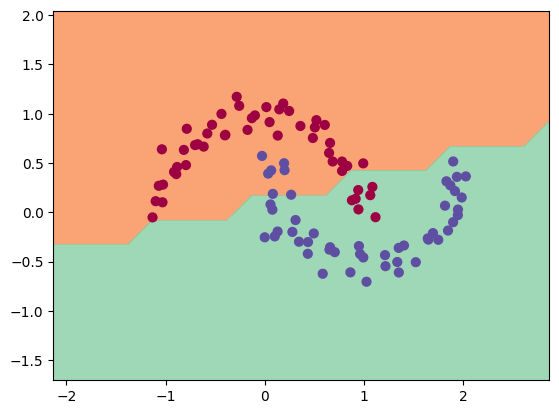

In [41]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Node, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())